In [19]:
import numpy as np
import pandas as pd
from IPython.display import Audio
from scipy.sparse.csgraph import connected_components
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

In [20]:
# Path to the .npz file
dataset_path = "../../MLPC2025_dataset"

annotations_path = dataset_path + "/annotations.csv"
annotations_text_embeddings_path = dataset_path + "/annotations_text_embeddings.npz"

metadata_path = dataset_path + "/metadata.csv"
metadata_title_embeddings_path = dataset_path + "/metadata_title_embeddings.npz"
metadata_keywords_embeddings_path = dataset_path + "/metadata_keywords_embeddings.npz"

audio_paths = dataset_path + "/audio"
audio_features_paths = dataset_path + "/audio_features"

In [21]:
annotations = pd.read_csv(annotations_path)
annotations['original_index'] = annotations.index
annotations.head()

,task_id,filename,annotator,text,onset,offset,filename_unsafe,original_index
0,161977861,560761.mp3,5945971035380930099053858595454362549806990533...,bird twitters nearby with a high pitch two times,16.552368,17.271435,560761_tufted titmouse calling.mp3,0
1,161987165,240538.mp3,4916274343929406460752597829190197300566135449...,A cow bell clinging repeatedly,12.265866,15.420303,240538_AMB - Cowbell stable Stereowav.mp3,1
2,161989998,660337.mp3,8960534646813062318784592632173589349806817458...,A child speaks with a high-pitched voice,12.493984,13.315680,660337_Aeroplane Takeoff From Cabinwav.mp3,2
3,161978339,725686.mp3,4540509031938851510799116530500792274849113758...,A high pitch meowing coming from a cat,16.018221,16.991704,725686_Black Cat Talking.mp3,3
4,161985729,97606.mp3,1085174475307080254018414698413953957857995126...,An extremely loud brushing sound on a construc...,0.000000,1.626352,97606_jackhammer med distwav.mp3,4


In [22]:
metadata = pd.read_csv(metadata_path)
metadata.head()

,filename,keywords,freesound_id,sound_link,manufacturer,license,title,description,num_downloads,geotag,start_time_s,end_time_s
0,617030.mp3,"atmosphere, general-noise, suburban, ambiance,...",617030,https://freesound.org/people/klankbeeld/sounds...,klankbeeld,https://creativecommons.org/licenses/by/4.0/,suburb night NL 1041PM 210415_0279.wav,Night in a suburban city. All sounds far. Tra...,65,51.7090740261 5.30657821347,15.6,43.535
1,637408.mp3,"jackhammer, construction, reflected",637408,https://freesound.org/people/kyles/sounds/637408/,kyles,http://creativecommons.org/publicdomain/zero/1.0/,construction jackhammer reflected5.flac,construction jackhammer reflected5\n\nrecorded...,23,NaN,209.8,232.356
2,615545.mp3,"river-side, field-recording, bell, fields, vil...",615545,https://freesound.org/people/klankbeeld/sounds...,klankbeeld,https://creativecommons.org/licenses/by/4.0/,4 church-bells 7AM at river NL 210718_0304.wav,Four differed church bells tell it is 7 o’cloc...,227,51.7405127581 5.23133654974,6.0,31.666
3,410867.mp3,"sports-crowd, applause, crowd, crowd-cheer, Ad...",410867,https://freesound.org/people/NobodyYouKnowOf/s...,NobodyYouKnowOf,http://creativecommons.org/publicdomain/zero/1.0/,crowd_the_hill_language.wav,Crowd making some noise at a SANFL Aussie rule...,308,-34.9157073897 138.596134186,19.8,48.569
4,65916.mp3,"bones, breaking, broken, chime, clatter, explo...",65916,https://freesound.org/people/BristolStories/so...,BristolStories,http://creativecommons.org/licenses/by-nc/3.0/,shells-tinkle.WAV,This is a shells wind chime. I used it for the...,7721,NaN,23.6,40.797


In [23]:
metadata_title_embeddings = np.load(metadata_title_embeddings_path)['embeddings']
metadata_keywords_embeddings = np.load(metadata_keywords_embeddings_path)['embeddings']

In [24]:
annotations_text_embeddings = np.load(annotations_text_embeddings_path)['embeddings']

In [25]:
embedding_dim = annotations_text_embeddings.shape[1]

(a) How many annotations did we collect per file? How many distinct sound events per file?

In [26]:
n_annotations_per_file = {}

for filename in annotations['filename'].unique():
    n_annotations_per_file[filename] = len(annotations[annotations['filename'] == filename])


In [27]:
n_distinct_sound_events_per_file = {}

for filename in annotations['filename'].unique():

    n_distinct_sound_events_estimate = 0

    file_annotations = annotations[annotations['filename'] == filename]
    file_annotations_grouped_by_annotator = file_annotations.groupby('annotator').agg(lambda x: list(x)).reset_index()

    annotators = file_annotations_grouped_by_annotator['annotator'].unique()

    for annotator in annotators:
        annotations_indices = file_annotations_grouped_by_annotator[file_annotations_grouped_by_annotator['annotator'] == annotator]['original_index'].values[0]

        annotations_embeddings = np.zeros((len(annotations_indices), embedding_dim))
        for i, index in enumerate(annotations_indices):
            annotations_embeddings[i] = annotations_text_embeddings[index]
        pairwise_similarities = np.dot(annotations_embeddings, annotations_embeddings.T)
        pairwise_similarities = np.tril(pairwise_similarities, k=-1)
        pairwise_similarities[pairwise_similarities < 0.9] = 0
        pairwise_similarities[pairwise_similarities >= 0.9] = 1

        graph = csr_matrix(pairwise_similarities)
        n_distinct_sound_events_estimate, labels = connected_components(csgraph=graph, directed=False)

    n_distinct_sound_events_estimate /= len(annotators)
    if n_distinct_sound_events_estimate < 1:
        n_distinct_sound_events_estimate = 1

    n_distinct_sound_events_per_file[filename] = n_distinct_sound_events_estimate

In [28]:
print(len(n_annotations_per_file))
print(len(n_distinct_sound_events_per_file))

9026
9026


96


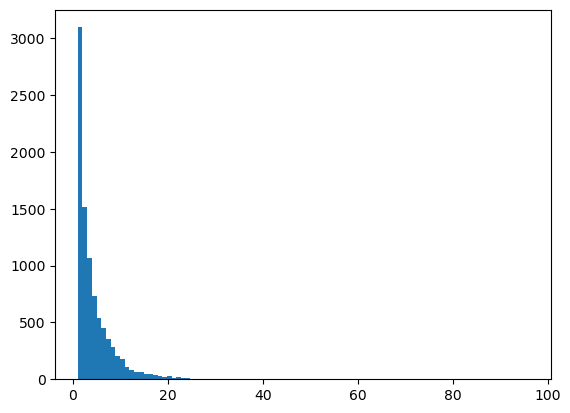

In [29]:
n_annotations_per_file_values = n_annotations_per_file.values()
max_annotations_per_file = max(n_annotations_per_file_values)
print(max_annotations_per_file)
plt.hist(n_annotations_per_file_values, bins=max_annotations_per_file)
plt.show()

21


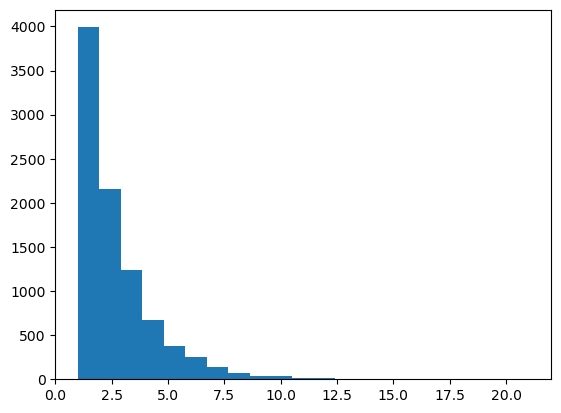

In [30]:
n_distinct_sound_events_per_file_values = list(n_distinct_sound_events_per_file.values())
n_distinct_sound_events_per_file_values = [round(x) for x in n_distinct_sound_events_per_file_values]
max_distinct_sound_events_per_file = max(n_distinct_sound_events_per_file_values)
print(max_distinct_sound_events_per_file)
plt.hist(n_distinct_sound_events_per_file_values, bins=max_distinct_sound_events_per_file)
plt.show()


(b) How detailed are the text annotations? How much does the quality of annotations vary between
different annotators?

In [31]:
#import language_tool_python
#tool = language_tool_python.LanguageTool('en-US')
from spellchecker import SpellChecker
spell = SpellChecker()

def calculate_ttr(text):

    tokens = text.split()
    unique_words = set(tokens)

    ttr = len(unique_words) / len(tokens) if tokens else 0
    return ttr


In [32]:
annotator_qualities = {}

annotations_grouped_by_annotator = annotations.groupby('annotator').agg(lambda x: list(x)).reset_index()
n_an = 0
for annotator in annotations_grouped_by_annotator['annotator'].unique():
    annotator_qualities[annotator] = {'ttr': None, 'errors': None}

    annotator_annotations = annotations_grouped_by_annotator[annotations_grouped_by_annotator['annotator'] == annotator]

    ttr_values = []
    errors = []
    n_words = []

    for texts in annotator_annotations['text'].values:
        for text in texts:
            n_an+=1
            ttr = calculate_ttr(text)
            ttr_values.append(ttr)

            misspelled = spell.unknown(text.split())
            errors.append(len(misspelled))

            n_words.append(len(text.split()))

    annotator_qualities[annotator]['ttr'] = np.array(ttr_values)
    annotator_qualities[annotator]['errors'] = np.array(errors)
    annotator_qualities[annotator]['n_words'] = np.array(n_words)

print(n_an)


35826


In [33]:
avg_ttrs = []
avg_errors = []
avg_n_words = []
for annotator, qualities in annotator_qualities.items():
    ttr = qualities['ttr']
    errors = qualities['errors']
    n_words = qualities['n_words']

    avg_ttr = np.average(ttr)
    avg_error = np.average(errors)
    avg_n_word = np.average(n_words)

    annotator_qualities[annotator]['avg_ttr'] = avg_ttr
    avg_ttrs.append(avg_ttr)
    annotator_qualities[annotator]['avg_errors'] = avg_error
    avg_errors.append(avg_error)
    annotator_qualities[annotator]['avg_n_words'] = avg_n_word
    avg_n_words.append(avg_n_word)

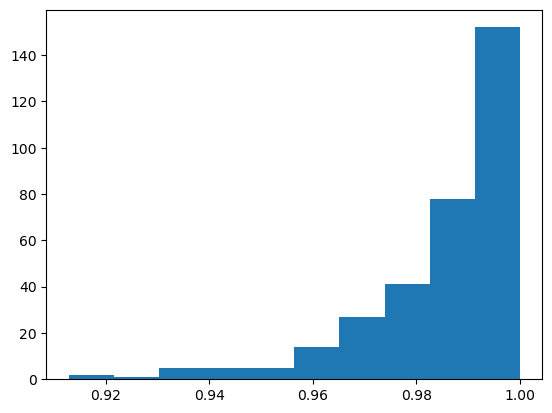

In [34]:
plt.hist(avg_ttrs)
plt.show()

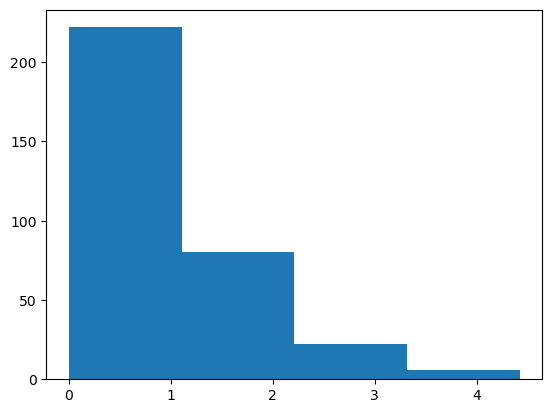

In [40]:
plt.hist(avg_errors, bins=4)
plt.show()

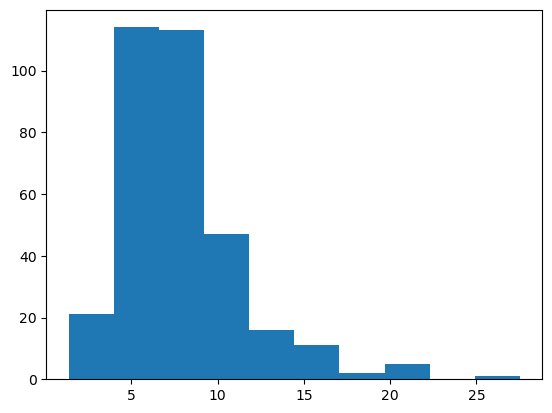

In [36]:
plt.hist(avg_n_words)
plt.show()